In [113]:
# dir paths
import os
from google.colab import drive
drive.mount('/content/gdrive')

base_path = "/content/gdrive/MyDrive/ai/hand_gesture"
os.chdir(base_path)
!ls
data_path = os.path.join(base_path, "data")
model_path = os.path.join(base_path, "models")
if not os.path.exists(model_path):
  os.mkdir(model_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
data				hand.jpg	       models
hand_gesture_recognition.ipynb	mediapipe_hands.ipynb  model-small-1


In [158]:
# Import libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import random
import matplotlib.pyplot as plt

In [115]:
df = pd.read_csv("data/train_gesture.csv")
df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)

In [116]:
len(df)

1888

In [117]:
len(df.columns)

43

In [118]:
cols = ['{}'.format(index) for index in range(1, 43)]
cols.append('gesture')
df.columns = cols
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,gesture
0,0.762950,0.353598,0.822610,0.310528,0.864088,0.235447,0.894293,0.181634,0.930240,0.166352,0.853985,0.148353,0.804502,0.091831,0.791643,0.125563,0.801182,0.155772,0.813495,0.144018,0.769434,0.091160,0.761205,0.124862,0.770330,0.155192,0.769511,0.149472,0.733444,0.099690,0.726711,0.135175,0.735156,0.168097,0.724388,0.162339,0.700064,0.119738,0.696066,0.151562,0.701961,0.182411,Thumbs Right
1,0.562010,0.620524,0.481135,0.592170,0.425301,0.557536,0.375446,0.524996,0.346184,0.497374,0.444458,0.478447,0.412747,0.447638,0.419950,0.473949,0.422133,0.470262,0.470849,0.453609,0.441180,0.422199,0.450996,0.455845,0.452399,0.444550,0.502478,0.438327,0.475847,0.399803,0.484915,0.438843,0.492591,0.440742,0.536920,0.424172,0.512643,0.393126,0.517398,0.423383,0.526706,0.431696,Thumbs Left
2,0.292929,0.855904,0.230818,0.829887,0.184629,0.765748,0.153743,0.709777,0.118049,0.672686,0.221551,0.639737,0.203133,0.564829,0.187187,0.522234,0.172145,0.484367,0.250053,0.628053,0.241403,0.533836,0.229576,0.475748,0.218402,0.426794,0.279229,0.635984,0.275330,0.545040,0.264405,0.489231,0.250707,0.440906,0.309590,0.660645,0.315718,0.594339,0.309164,0.552225,0.298489,0.513483,Palm
3,0.592787,0.391398,0.526618,0.375121,0.490645,0.304149,0.503456,0.237781,0.527944,0.194260,0.504451,0.230952,0.475980,0.175581,0.477289,0.228088,0.491313,0.272458,0.539824,0.215818,0.510647,0.149230,0.510512,0.222699,0.527261,0.265847,0.578309,0.212590,0.550184,0.157065,0.549111,0.236271,0.566250,0.275501,0.623459,0.216225,0.589048,0.177928,0.583003,0.230543,0.595884,0.259816,Fist
4,0.854380,0.641206,0.780927,0.576074,0.735909,0.510977,0.699211,0.447363,0.666323,0.395831,0.772726,0.405423,0.766254,0.316381,0.768437,0.263717,0.772492,0.215465,0.818151,0.406118,0.830677,0.334647,0.829657,0.420007,0.823433,0.478102,0.863132,0.419520,0.870574,0.366278,0.865270,0.444182,0.856558,0.483903,0.903713,0.437975,0.910661,0.392372,0.900485,0.446650,0.890040,0.477882,One Index


In [119]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
count,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000
mean,0.587279,0.632191,0.546040,0.604155,0.504725,0.547792,0.478261,0.499056,0.459163,0.468447,0.511120,0.465331,0.477445,0.415395,0.483337,0.415321,0.493609,0.409242,0.528226,0.462325,0.497389,0.412013,0.507571,0.430734,0.519320,0.432563,0.547077,0.471120,0.518204,0.433969,0.525618,0.471236,0.535789,0.487422,0.567985,0.486504,0.542937,0.456615,0.545888,0.483706,0.553527,0.497775
std,0.197285,0.198731,0.198272,0.182670,0.203772,0.171686,0.211804,0.174432,0.223477,0.184507,0.205656,0.165333,0.208552,0.168818,0.207650,0.172615,0.207943,0.181524,0.206849,0.171437,0.212629,0.178676,0.208903,0.189826,0.205396,0.202720,0.209934,0.182678,0.217640,0.190145,0.212468,0.197952,0.207430,0.205904,0.215043,0.196979,0.222224,0.200705,0.217263,0.204133,0.212379,0.208232
min,0.217900,0.098340,0.150006,0.180749,0.082594,0.191232,0.024718,0.141444,-0.022063,0.062868,0.122414,0.078793,0.063143,0.042461,0.045552,0.086039,0.016139,0.056132,0.109512,0.064066,0.058475,0.021709,0.069027,0.041164,0.040964,-0.019493,0.106206,0.069872,0.061885,0.022619,0.071032,0.054613,0.089500,-0.003085,0.109090,0.068152,0.057349,0.031374,0.033653,0.057868,0.013748,0.074595
25%,0.426671,0.488375,0.393432,0.452057,0.348179,0.403799,0.312702,0.367773,0.281063,0.334079,0.350237,0.333722,0.315196,0.286629,0.321795,0.272914,0.327661,0.263445,0.368746,0.334833,0.334405,0.272556,0.345815,0.266189,0.361483,0.265630,0.375828,0.335614,0.340537,0.285758,0.350228,0.309938,0.367219,0.323819,0.375155,0.336808,0.352388,0.298525,0.356662,0.312383,0.366065,0.326366
50%,0.604394,0.645915,0.567356,0.614170,0.527960,0.556769,0.506458,0.503400,0.488671,0.472095,0.525995,0.469878,0.499246,0.413920,0.505450,0.402839,0.518295,0.389529,0.549710,0.467398,0.517012,0.408457,0.526949,0.417056,0.538749,0.416355,0.553323,0.479757,0.527748,0.442341,0.538987,0.474104,0.548662,0.500142,0.576116,0.498543,0.547189,0.475716,0.555329,0.499479,0.569098,0.509529
75%,0.752600,0.797864,0.719180,0.753965,0.672426,0.692410,0.644274,0.639739,0.616967,0.609068,0.704215,0.606276,0.665982,0.542583,0.678286,0.541682,0.696413,0.542644,0.731538,0.603496,0.689590,0.551329,0.695319,0.581283,0.711460,0.597858,0.740029,0.613735,0.709959,0.582306,0.711199,0.625443,0.720277,0.652103,0.760391,0.635923,0.726572,0.607068,0.726597,0.642103,0.735575,0.663869
max,0.949622,1.003084,0.913924,0.972857,0.869090,0.923687,0.899352,0.907982,0.937422,0.954878,0.889301,0.798031,0.826962,0.824881,0.839037,0.862416,0.834732,0.878921,0.896701,0.868470,0.866980,0.868247,0.879503,0.873989,0.872129,0.877638,0.909951,0.938555,0.910787,0.928597,0.919688,0.922480,0.910586,0.923802,0.948605,0.995734,0.948176,0.978250,0.949830,0.972930,0.941951,0.979778


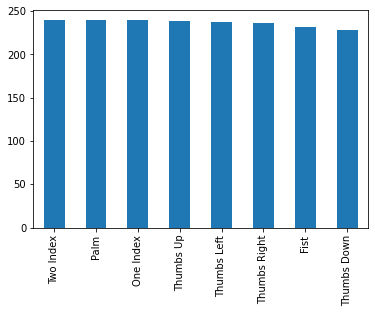

In [120]:
# check for class imbalance
df.gesture.value_counts().plot.bar()

In [121]:
class_value_dict = {
  "Thumbs Up" : 0,
  "Thumbs Down" : 1,
  "Thumbs Right" : 2,
  "Thumbs Left" : 3,
  "Palm" : 4,
  "Fist" : 5,
  "One Index" : 6,
  "Two Index" : 7
}
df['gesture'] =  df['gesture'].apply(lambda value : class_value_dict[value])
df.gesture.value_counts()

7    239
6    239
4    239
0    238
3    237
2    236
5    232
1    228
Name: gesture, dtype: int64

In [122]:
x_cols = [col for col in df.columns if col != "gesture"]
y_col = "gesture"
np.array(x_cols), y_col

(array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
        '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
        '35', '36', '37', '38', '39', '40', '41', '42'], dtype='<U2'),
 'gesture')

In [123]:
X = df[x_cols]
y = df[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1416, 42), (472, 42), (1416,), (472,))

In [134]:
# Create model
num_classes = 8

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(42,)))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.20))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.10))
model.add(BatchNormalization())

model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 32)                1376      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dense_29 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)               

In [130]:
# Model checkpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True,
                                                save_weights_only=False, mode='auto')

# Early Stopping Callback
es = tf.keras.callbacks.EarlyStopping(patience=80, verbose=1)

In [135]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [136]:
history = model.fit(
    X_train,
    y_train,
    epochs=800,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, es]
)

Epoch 1/800
23/23 [==============================] - 1s 21ms/step - loss: 2.3092 - accuracy: 0.1822 - val_loss: 2.0661 - val_accuracy: 0.1928

Epoch 00001: val_loss did not improve from 0.03659
Epoch 2/800
23/23 [==============================] - 0s 7ms/step - loss: 1.7185 - accuracy: 0.3821 - val_loss: 2.0032 - val_accuracy: 0.2839

Epoch 00002: val_loss did not improve from 0.03659
Epoch 3/800
23/23 [==============================] - 0s 8ms/step - loss: 1.3491 - accuracy: 0.5438 - val_loss: 1.9321 - val_accuracy: 0.4619

Epoch 00003: val_loss did not improve from 0.03659
Epoch 4/800
23/23 [==============================] - 0s 7ms/step - loss: 1.1365 - accuracy: 0.6497 - val_loss: 1.8824 - val_accuracy: 0.4449

Epoch 00004: val_loss did not improve from 0.03659
Epoch 5/800
23/23 [==============================] - 0s 8ms/step - loss: 0.9381 - accuracy: 0.7338 - val_loss: 1.8385 - val_accuracy: 0.4131

Epoch 00005: val_loss did not improve from 0.03659
Epoch 6/800
23/23 [===============

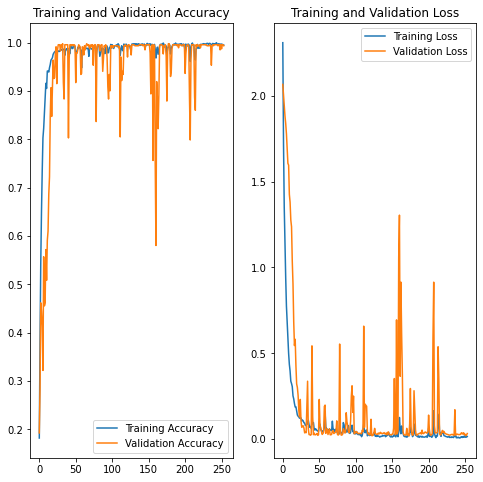

In [138]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(254)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Load model and predict on test set

In [139]:
from tensorflow.keras.models import load_model

In [140]:
best_model = load_model(os.path.join(model_path))

In [60]:
test_df = pd.read_csv(os.path.join(data_path, "test_gesture.csv"))
cols = ['{}'.format(index) for index in range(1, 43)]
cols.append('gesture')
test_df.columns = cols
class_value_dict = {
  "Thumbs Up" : 0,
  "Thumbs Down" : 1,
  "Thumbs Right" : 2,
  "Thumbs Left" : 3,
  "Palm" : 4,
  "Fist" : 5,
  "One Index" : 6,
  "Two Index" : 7
}
test_df['gesture'] =  test_df['gesture'].apply(lambda value : class_value_dict[value])
test_df.gesture.value_counts()

7    42
5    42
3    42
6    41
4    39
2    39
0    32
1    28
Name: gesture, dtype: int64

In [61]:
test_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,gesture
0,0.738882,0.686563,0.710759,0.565102,0.650537,0.461068,0.610338,0.379500,0.600410,0.301417,0.602768,0.485850,0.512135,0.517351,0.536365,0.534001,0.572292,0.523584,0.592034,0.562741,0.504714,0.572919,0.529865,0.582879,0.563465,0.575952,0.588373,0.640149,0.506220,0.639621,0.532529,0.649481,0.566139,0.647884,0.587843,0.712689,0.521552,0.698038,0.549201,0.701234,0.581794,0.702172,0
1,0.721160,0.661780,0.685148,0.540205,0.624361,0.444870,0.586139,0.358389,0.573552,0.276805,0.553947,0.473416,0.508847,0.484297,0.527194,0.500928,0.545645,0.506478,0.541638,0.541377,0.502585,0.543872,0.515288,0.552794,0.525597,0.552984,0.541139,0.610381,0.500292,0.601337,0.508630,0.604768,0.519654,0.608324,0.545808,0.669860,0.506550,0.661121,0.507592,0.656245,0.508265,0.653504,0
2,0.631207,0.491109,0.620590,0.389507,0.562475,0.293696,0.524425,0.212531,0.518604,0.134343,0.507065,0.322386,0.399313,0.328933,0.349077,0.344379,0.310449,0.355472,0.499201,0.392065,0.393990,0.399253,0.350542,0.416469,0.321433,0.426771,0.501350,0.465383,0.428056,0.471326,0.452726,0.484550,0.483730,0.485669,0.509343,0.536239,0.456538,0.535009,0.479984,0.538218,0.507523,0.536088,0
3,0.656360,0.491565,0.636310,0.384569,0.572893,0.282203,0.533256,0.201059,0.526696,0.121437,0.524389,0.300412,0.413490,0.344693,0.392790,0.375410,0.381832,0.387260,0.518888,0.374145,0.402971,0.407771,0.351435,0.427923,0.312659,0.436584,0.523531,0.454534,0.426038,0.485634,0.450183,0.496282,0.482029,0.493189,0.531085,0.534689,0.457458,0.546273,0.477513,0.547837,0.503079,0.540954,0
4,0.681821,0.493874,0.660742,0.382162,0.600119,0.280165,0.556879,0.200448,0.548819,0.114980,0.529135,0.300106,0.457228,0.340911,0.487075,0.368353,0.527764,0.364479,0.522667,0.377314,0.455022,0.406326,0.484951,0.425089,0.519822,0.420784,0.529548,0.458644,0.467361,0.471179,0.491252,0.488084,0.519736,0.487114,0.543005,0.537362,0.483933,0.543426,0.485191,0.549447,0.489480,0.548587,0


In [72]:
test_df[x_cols][:1].values

(1, 42)

In [141]:
np.set_printoptions(suppress=True)
best_model.predict(test_df[x_cols][:1].values)

array([[0.99999356, 0.00000002, 0.00000024, 0.00000004, 0.00000599,
        0.00000005, 0.00000009, 0.00000004]], dtype=float32)

In [93]:
test_df[x_cols][:1].values.shape

(1, 42)

In [146]:
rand_arr = np.array([random.uniform(0,1) for i in range(42)]).reshape(1, 42)
best_model.predict(rand_arr)

array([[0.00000111, 0.00015513, 0.        , 0.9992174 , 0.00016414,
        0.        , 0.0004622 , 0.        ]], dtype=float32)

In [148]:
test_X = test_df[x_cols].values
test_y = test_df[y_col].values
y_preds = best_model.predict(test_X)

In [157]:
# caculate accuracy
scores_test = best_model.evaluate(test_X, test_y)
print("\n%s: %.2f%%" % (best_model.metrics_names[1], scores_test[1]*100))

10/10 [==============================] - 0s 4ms/step - loss: 0.1219 - accuracy: 0.9803

accuracy: 98.03%
